In [1]:
dataset = "merfish"
figdir = "C:\\Users\\Clarence (Admin)\\bento-manuscript\\figures"

# Setup


In [2]:
import bento as bt
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from statannotations.Annotator import Annotator

bt.settings.verbosity = 'INFO'

# Quality Control


In [3]:
adata = bt.ds.load_dataset(dataset)

Remove cells without nuclei


In [4]:
adata = adata[adata.obs["nucleus_shape"] != None]

Check QC distributions


In [5]:
bt.tl.obs_stats(adata)


  0%|          | 0/3 [00:00<?, ?it/s]

[15:39:19] INFO     AnnData object modified:                                                        _settings.py:48
                        obs:                                                                                       
                            + cell_aspect_ratio, cell_area, cell_density                                           

  0%|          | 0/3 [00:00<?, ?it/s]

[15:39:23] INFO     AnnData object modified:                                                        _settings.py:48
                        obs:                                                                                       
                            + nucleus_aspect_ratio, nucleus_area, nucleus_density                                  

Saved to C:\Users\Clarence (Admin)\bento-manuscript\figures\merfish_obs_stats.svg


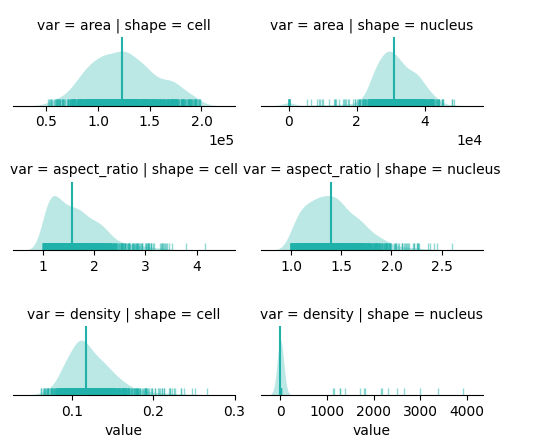

In [6]:
bt.pl.obs_stats(
    adata, rug=True, fname=f"{figdir}\merfish_obs_stats.svg"
)

## Filter out poor quality cells.

- remove cells with extremely small nuclei


Perform filtering


In [7]:
adata = adata[adata.obs["nucleus_area"] >= 10000]

In [8]:
adata.shape

(1000, 135)

In [9]:
bt.pl.obs_stats(adata)

# Compare clq distributions


In [10]:
adata.obs["cytoplasm_shape"] = bt.geo.get_shape(
    adata, "cell_shape"
) - bt.geo.get_shape(adata, "nucleus_shape")

adata.uns["points"]["cytoplasm"] = adata.uns["points"]["nucleus"] != -1

In [11]:
shapes = ["nucleus_shape", "cytoplasm_shape"]
bt.tl.coloc_quotient(
    adata, shapes=shapes, radius=20, min_points=10, min_cells=0
)

nucleus_shape:   0%|          | 0/1000 [00:00<?, ?it/s]

cytoplasm_shape:   0%|          | 0/1000 [00:00<?, ?it/s]

[15:44:20] INFO     AnnData object modified:                                                        _settings.py:48
                        uns:                                                                                       
                            + clq                                                                                  

In [12]:
clq_long = []
for shape, clq in adata.uns["clq"].items():
    clq["compartment"] = shape.split("_")[0]
    clq_long.append(clq)

clq_long = pd.concat(clq_long, axis=0)
clq_long["self"] = clq_long["gene"] == clq_long["neighbor"]
clq_long["self"] = clq_long["self"].map({True: "self", False: "pair"})
# clq_long["log(clq + 1)"] = np.log2(clq_long["clq"] + 1)
clq_long = clq_long.query("clq > 0").sort_values("log_clq")

In [13]:
sns.clustermap(
    clq_long.groupby(["compartment", "gene", "neighbor"])
    .agg("mean")
    .reset_index()
    .query('compartment == "nucleus"')
    .pivot(index="gene", columns="neighbor", values="log_clq")
    .fillna(0),
    cmap="RdBu_r",
    center=0,
    z_score=1,
)

In [14]:
clq_long.groupby(["compartment", "self"]).size()

compartment  self
cytoplasm    pair    12254430
             self      115187
nucleus      pair     6778402
             self       86474
dtype: int64

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
sns.violinplot(
    data=clq_long,
    y="self",
    x="log_clq",
    hue="compartment",
    split=True,
    inner="quartiles",
    cut=0,
    palette=sns.color_palette(["#DDD", "#AAA"]),
    ax=ax,
)

# n_samples = clq_long.groupby(["compartment", "self"]).size()

# xticklabels = []
# for compartment, row in zip(
#     clq_long["compartment"].unique(), n_samples.values.reshape(2, 2)
# ):
#     cat_ns = ", ".join([str(v) for v in row])
#     xticklabels.append("n = " + cat_ns + f"\n{compartment}")

# ax.set_xticklabels(xticklabels)
ax.set_ylabel(None)
ax.legend()
sns.despine()

# Pairwise tests of significance (with correction)
pairs = [
    (("pair", "cytoplasm"), ("self", "cytoplasm")),
    (("pair", "nucleus"), ("self", "nucleus")),
    (("pair", "cytoplasm"), ("pair", "nucleus")),
    (("self", "cytoplasm"), ("self", "nucleus")),
]

annotator = Annotator(
    ax,
    pairs,
    data=clq_long,
    y="self",
    x="log_clq",
    hue="compartment",
    orient="h",
)
annotator.configure(
    test="Mann-Whitney",
    comparisons_correction="Benjamini-Hochberg",
    text_format="star",
    loc="outside",
)
annotator.apply_and_annotate()

fname = f"{figdir}\{dataset}_clq_dists.svg"
rc = {"svg.fonttype": "none", "font.family": "Arial"}
with plt.rc_context(rc):
    plt.savefig(fname, dpi=400)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

self_cytoplasm vs. self_nucleus: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:0.000e+00 U_stat=6.086e+09
pair_cytoplasm vs. pair_nucleus: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:0.000e+00 U_stat=4.224e+13
pair_cytoplasm vs. self_cytoplasm: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:0.000e+00 U_stat=1.876e+11
pair_nucleus vs. self_nucleus: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:0.000e+00 U_stat=8.757e+10


In [16]:
clq_long.query('gene == "MALAT1" & neighbor == "CNR2"').groupby("compartment").mean()

,clq,log_clq
compartment,,
cytoplasm,163.395849,7.064930
nucleus,166.780195,7.218959


# Tensor decomposition


In [17]:
ranks = range(2, 11)
ranks = [4]
bt.tl.colocation(adata, ranks, iterations=3)

Preparing tensor...
(2, 1000, 18225)
:running: Decomposing tensor...


Device cuda:   0%|          | 0/1 [00:00<?, ?it/s]

:heavy_check_mark: Done.


[15:46:56] INFO     AnnData object modified:                                                        _settings.py:48
                        uns:                                                                                       
                            + factors_error, tensor_names, tensor_labels, tensor, factors                          

Saved to C:\Users\Clarence (Admin)\bento-manuscript\figures\merfish_coloc4.svg
Saved to C:\Users\Clarence (Admin)\bento-manuscript\figures\merfish_coloc4_self.svg


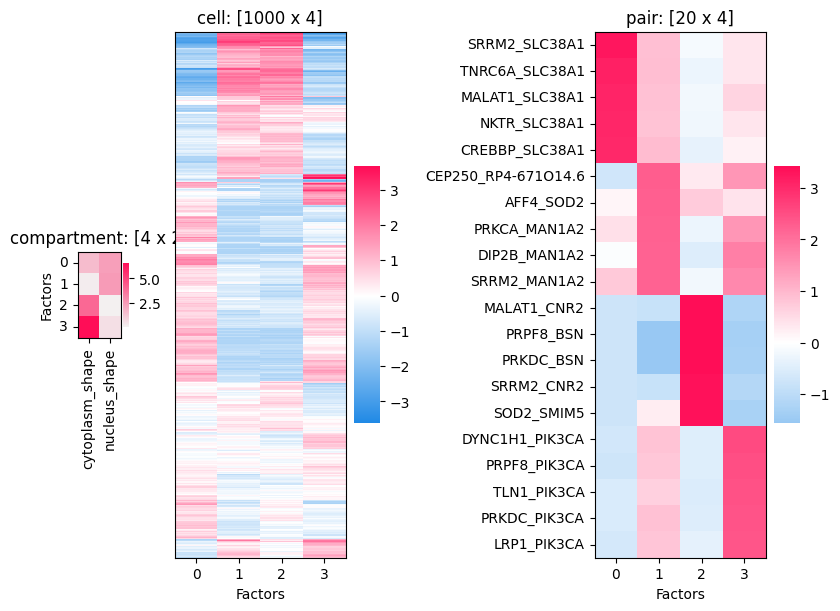

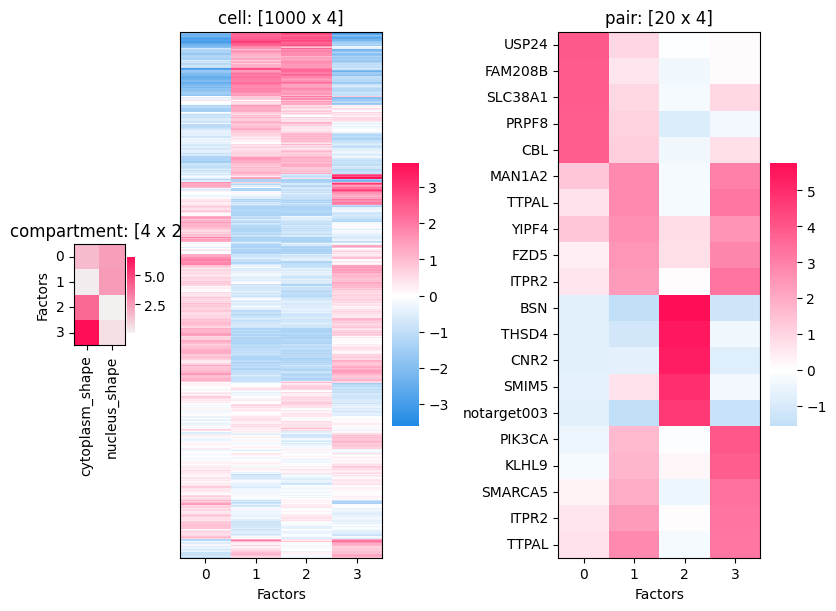

In [31]:
rank = 4

hm_params = dict(
    show_labels=[True, False, True],
    z_score=[False, True, True],
    cluster=[False, True, False],
)

# without self pairs
bt.pl.colocation(
    adata,
    rank,
    n_top=[None, None, 5],
    cut=[None, None, None],
    self_pairs=False,
    **hm_params,
    fname=f"{figdir}\{dataset}_coloc{rank}.svg",
)

# only self pairs
bt.pl.colocation(
    adata,
    rank,
    n_top=[None, None, 5],
    cut=[None, 5, None],
    self_pairs="only",
    **hm_params,
    fname=f"{figdir}\{dataset}_coloc{rank}_self.svg",
)

# Cell associations


In [19]:
cell_factor = pd.DataFrame(
    adata.uns["factors"][rank][1], index=adata.uns["tensor_labels"]["cell"]
)

cell_morphology = adata.obs[
    [
        "cell_area",
        "cell_density",
        "cell_aspect_ratio",
        "nucleus_area",
        "nucleus_density",
        "nucleus_aspect_ratio",
    ]
]

cell_all = cell_factor.join(cell_morphology)

In [20]:
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

cell_corr = cell_all.corr("pearson")
pval = cell_all.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(
    *cell_corr.shape
)
qval = multipletests(pval.values.flatten())[1].reshape(pval.shape)
qval = pd.DataFrame(qval, index=pval.index, columns=pval.columns)

p = qval.applymap(lambda x: "".join(["*" for t in [0.001] if x <= t]))

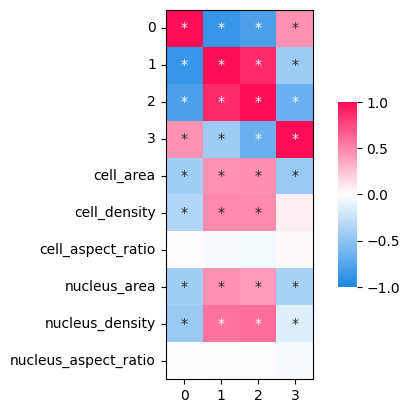

In [30]:
%matplotlib inline
ax = sns.heatmap(
    cell_corr.loc[:, range(rank)],
    cmap="red2blue",
    square=True,
    center=0,
    fmt="",
    vmin=-1,
    vmax=1,
    annot=p.loc[:, range(rank)],
    cbar_kws=dict(shrink=0.5, aspect=10),
)
sns.despine(ax=ax, top=False, right=False)

fname = f"{figdir}\{dataset}_cell_corr.svg"
rc = {"svg.fonttype": "none", "font.family": "Arial"}
with plt.rc_context(rc):
    plt.savefig(fname, dpi=400)

# Colocalization examples


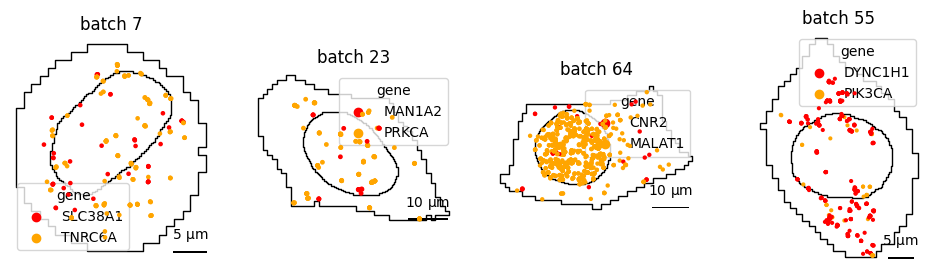

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

In [ ]:
%matplotlib inline
factors = [0, 1, 2, 3]
cells = ["10-7", "5-23", "29-64", "39-55"]
genes = [
    ["TNRC6A", "SLC38A1"],
    ["PRKCA", "MAN1A2"],
    ["MALAT1", "CNR2"],
    ["DYNC1H1", "PIK3CA"],
]
sizes = [11, 12, 10, 9]
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for f, cell, pair, s, ax in zip(factors, cells, genes, sizes, axes):
    plt.figure(figsize=(3,3))
    bt.pl.points(
        adata[cell, pair],
        hue="gene",
        palette=["red", "orange"],
        shapes_kws=dict(lw=1),
        s=s,
        frame_visible=False,
        title=None,
        ax=ax
        # point_kws=dict(s=s),
        # fname=f"{figdir}/merfish/f{f}_{'_'.join(pair)}.svg",
    )
    plt.tight_layout()
    # break

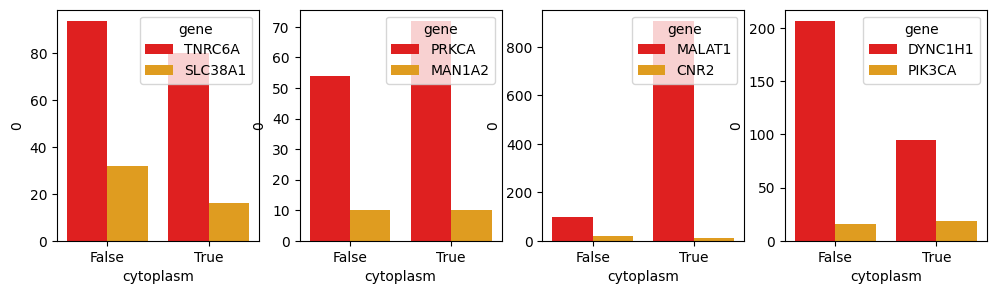

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for f, cell, pair, s, ax in zip(factors, cells, genes, sizes, axes):
    pts = adata.uns['points']
    pts = pts[pts['cell'] == cell]
    pts = pts[pts['gene'].isin(pair)]
    pts['gene'] = pts['gene'].astype(str)
    gene_counts = pts[['gene', 'cytoplasm']].value_counts().reset_index()
    sns.barplot(x='cytoplasm', y=0, hue='gene', data=gene_counts, palette=['red', 'orange'], ax=ax)
    # break